In [1]:
#!/usr/bin/env python
#
# Simple DMRG tutorial.  This code contains a basic implementation of the
# infinite system algorithm
#
# Copyright 2013 James R. Garrison and Ryan V. Mishmash.
# Open source under the MIT license.  Source code at
# <https://github.com/simple-dmrg/simple-dmrg/>

# This code will run under any version of Python >= 2.6.  The following line
# provides consistency between python2 and python3.
from __future__ import print_function, division  # requires Python >= 2.6

# numpy and scipy imports
import numpy as np
from scipy.sparse import kron, identity, csr_matrix
from scipy.sparse.linalg import eigsh  # Lanczos routine from ARPACK
from scipy.linalg import eigh, norm, svd
# We will use python's "namedtuple" to represent the Block and EnlargedBlock
# objects
from collections import namedtuple
import matplotlib.pyplot as plt

In [2]:
#system block
SysBlock = namedtuple("SysBlock", ["length", "basis_size", "operator_dict"])
EnlargedsysBlock = namedtuple("EnlargedsysBlock", ["length", "basis_size", "operator_dict"])

#env block
EnvBlock = namedtuple("EnvBlock", ["length", "basis_size", "operator_dict"])
EnlargedenvBlock = namedtuple("EnlargedenvBlock", ["length", "basis_size", "operator_dict"])

In [3]:
# Model-specific code for the Heisenberg XXZ chain
model_d = 2  # single-site basis size

Sz1 = 2*np.array([[0.5, 0], [0, -0.5]], dtype='d')  # single-site S^z
Sx1 = 2*np.array([[0, 0.5], [0.5, 0]], dtype='d')  # single-site S^x


In [4]:
def rotate_and_truncate(operator, transformation_matrix):
    """Transforms the operator to the new (possibly truncated) basis given by
    `transformation_matrix`.
    """
    return csr_matrix(csr_matrix.getH(transformation_matrix)@operator@transformation_matrix)

In [5]:
def enlarge_sysblock(J,h,block):
    """This function enlarges the provided Block by a single site, returning an
    EnlargedBlock.
    """
    mblock = block.basis_size
    o = block.operator_dict
    # Create the new operators for the enlarged block.  Our basis becomes a
    # Kronecker product of the Block basis and the single-site basis.  NOTE:
    # `kron` uses the tensor product convention making blocks of the second
    # array scaled by the first.  As such, we adopt this convention for
    # Kronecker products throughout the code.
    enlarged_operator_dict = {
        "H": kron(o["H"], identity(model_d)) +h*kron(identity(mblock),Sx1)+J*kron(o["conn_Sz"],Sz1),
        "Magz":kron(o["Magz"], identity(model_d)) + kron(identity(mblock),Sz1),
        "Magx":kron(o["Magx"], identity(model_d)) + kron(identity(mblock),Sx1),
        "conn_Sz": kron(identity(mblock), Sz1),
        "conn_Sx": kron(identity(mblock), Sx1),
    }

    return EnlargedsysBlock(length=(block.length + 1),
                         basis_size=(block.basis_size * model_d),
                         operator_dict=enlarged_operator_dict)


In [6]:
def enlarge_envblock(J,h,block):
    """This function enlarges the provided Block by a single site, returning an
    EnlargedBlock.
    """
    mblock = block.basis_size
    o = block.operator_dict
    # Create the new operators for the enlarged block.  Our basis becomes a
    # Kronecker product of the Block basis and the single-site basis.  NOTE:
    # `kron` uses the tensor product convention making blocks of the second
    # array scaled by the first.  As such, we adopt this convention for
    # Kronecker products throughout the code.
    enlarged_operator_dict = {
        #"H": kron(identity(model_d),o["H"])+h*kron(Sx1,identity(np.size(o["conn_Sx"],0)))+J*kron(Sz1,o["conn_Sz"]),
        "H": kron(identity(model_d),o["H"])+h*kron(Sx1,identity(mblock))+J*kron(Sz1,o["conn_Sz"]),
        "Magz":kron(identity(model_d),o["Magz"]) + kron(Sz1,identity(mblock)),
        "Magx":kron(identity(model_d),o["Magx"]) + kron(Sx1,identity(mblock)),
        #"H": kron(identity(model_d),o["H"]) - h*kron(identity(model_d),o["conn_Sx"])-J*kron(o["conn_Sz"],Sz1),
        "conn_Sz": kron(Sz1,identity(mblock)),
        "conn_Sx": kron(Sx1,identity(mblock)),
    }

    return EnlargedenvBlock(length=(block.length + 1),
                         basis_size=(block.basis_size * model_d),
                         operator_dict=enlarged_operator_dict)


In [61]:
def single_dmrg_step(J,h,sys, env, m):
    """Performs a single DMRG step using `sys` as the system and `env` as the
    environment, keeping a maximum of `m` states in the new basis.
    """
    #assert is_valid_block(sys)
    #assert is_valid_block(env)

    # Enlarge each block by a single site.
    sys_enl = enlarge_sysblock(J,h,sys)
    env_enl = enlarge_envblock(J,h,env)
    
#     if sys is env:  # no need to recalculate a second time
#         env_enl = sys_enl
#     else:
#         env_enl = enlarge_block(env)

#     assert is_valid_enlarged_block(sys_enl)
#     assert is_valid_enlarged_block(env_enl)

    # Construct the full superblock Hamiltonian.
    m_sys_enl = sys_enl.basis_size
    m_env_enl = env_enl.basis_size
    sys_enl_op = sys_enl.operator_dict
    env_enl_op = env_enl.operator_dict
    superblock_hamiltonian = kron(sys_enl_op["H"], identity(m_env_enl)) + kron(identity(m_sys_enl), env_enl_op["H"]) \
                             +J*kron(sys_enl_op["conn_Sz"], env_enl_op["conn_Sz"])
    superblock_magz = kron(sys_enl_op["Magz"], identity(m_env_enl)) + kron(identity(m_sys_enl), env_enl_op["Magz"])
    superblock_magx = kron(sys_enl_op["Magx"], identity(m_env_enl)) + kron(identity(m_sys_enl), env_enl_op["Magx"])
    # Call ARPACK to find the superblock ground state.  ("SA" means find the
    # "smallest in amplitude" eigenvalue.)
    energy, psi0 = eigsh(superblock_hamiltonian, k=1, which="SA", tol=0)
    #energy = ener[0]
    #psi0 = vec[:,0]
    #perturb
    #lam = 0.01
    #fs = psi0 + vec[:,1]*lam*(vec[:,1].T @superblock_magx@vec[:,0])/(ener[0]-ener[1])
    expect_magz = psi0.T@superblock_magz@psi0
    expect_magx = psi0.T@superblock_magx@psi0
    #fd = abs(fs.T@psi0)
    #rho = psi0@csr_matrix.getH(psi0)
    #ent_s = -np.trace(rho@logm(rho))
    
    tol = 1e-10
    psi0.real[abs(psi0.real) < tol] = 0.0
    psi0 = psi0/norm(psi0)
    
    #expect_magz = psi0.T.conjugate()@superblock_magz@psi0
    #expect_magx = psi0.T@superblock_magx@psi0

    # Construct the reduced density matrix of the system by tracing out the
    # environment
    #
    # We want to make the (sys, env) indices correspond to (row, column) of a
    # matrix, respectively.  Since the environment (column) index updates most
    # quickly in our Kronecker product structure, psi0 is thus row-major ("C
    # style").
    if sys_enl.basis_size>=env_enl.basis_size:
        psi0_sys = psi0.reshape([sys_enl.basis_size, -1], order="C")
        u, s, vh=svd(psi0_sys,full_matrices=False)
        s = np.diag(s, k=0)
        rho_sys = u@s@s@csr_matrix.getH(u)
        rho_env = csr_matrix.getH(vh)@s@s@vh
        #ent_sys = -np.trace(rho_sys@logm(rho_sys))
        #ent_env = -np.trace(rho_env@logm(rho_env))
        #ent_s = ent_env + ent_sys
    else:
        psi0_sys = psi0.reshape([sys_enl.basis_size, -1], order="C")
        u, s, vh=svd(psi0_sys,full_matrices=False)
        s = np.diag(s, k=0)
        rho_sys = u@s@s.conjugate()@csr_matrix.getH(u)
        rho_env = csr_matrix.getH(vh)@s@s@vh
        
    #ent_s = -np.trace(rho@logm(rho))
    # Diagonalize the reduced density matrix and sort the eigenvectors by
    # eigenvalue.
    evals_sys, evecs_sys = eigh(rho_sys)
    evals_env, evecs_env = eigh(rho_env)

    #Build the transformation matrix from the `m` overall most significant
    #eigenvectors.
    my_sysm = min(sys_enl.basis_size,m)
    my_envm = min(env_enl.basis_size,m)
    transformation_matrix_sys = np.zeros((sys_enl.basis_size, my_sysm), dtype='d', order='F')
    transformation_matrix_env = np.zeros((env_enl.basis_size, my_envm), dtype='d', order='F')
    for i in range(my_sysm):
        transformation_matrix_sys[:,i] = evecs_sys[:,sys_enl.basis_size-i-1]
    for i in range(my_envm):
        transformation_matrix_env[:,i] = evecs_env[:,env_enl.basis_size-i-1]
    
    truncation_error = sum([eig1 for eig1 in evals_sys[0:sys_enl.basis_size-m]])
    #print("truncation error:", truncation_error)

    # Rotate and truncate each operator.
    new_sys_operator_dict = {}
    for name, op in sys_enl.operator_dict.items():
        new_sys_operator_dict[name] = rotate_and_truncate(op, transformation_matrix_sys)
        #new_operator_dict[name] = op
    newsysblock = SysBlock(length=sys_enl.length,
                     basis_size=my_sysm,
                     operator_dict=new_sys_operator_dict)    
    
    new_env_operator_dict = {}
    for name, op in env_enl.operator_dict.items():
        new_env_operator_dict[name] = rotate_and_truncate(op, transformation_matrix_env)
        #new_operator_dict[name] = op
    newenvblock = EnvBlock(length=env_enl.length,
                     basis_size=my_envm,
                     operator_dict=new_env_operator_dict)    
    
    return newsysblock, newenvblock, energy, expect_magz, expect_magx, psi0

In [60]:
def infinite_system_algorithm(J,h,L, m):
    H1 = h*Sx1 + 1e-9*Sz1
    Magz1 = Sz1
    Magx1 = Sx1
    initial_block = SysBlock(length=1, basis_size=model_d, operator_dict={
        "H": H1,
        "Magz":Magz1,
        "Magx":Magx1,
        "conn_Sz": Sz1,
        "conn_Sx": Sx1,
        })
    sysblock = initial_block
    envblock = initial_block
    # Repeatedly enlarge the system by performing a single DMRG step, using a
    # reflection of the current block as the environment.
    while 2 * sysblock.length < L:
        #print("L =", block.length * 2 + 2)
        sysblock, envblock, energy, expect_magz, expect_magx, psi0 = single_dmrg_step(J,h,sysblock, envblock, m=m)
    #print("E/L =", energy / (block.length * 2))
    #print("Magz/L =", expect_magz / (block.length * 2))
    #print("Magx/L =", expect_magx / (block.length * 2))
    #print("L =", block.length * 2)
    EXP_MAGZ = expect_magz / (sysblock.length * 2)
    EXP_MAGX = expect_magx / (sysblock.length * 2)
    return energy, EXP_MAGZ,EXP_MAGX, psi0

In [58]:
energy, EXP_MAGZ,EXP_MAGX,fd = infinite_system_algorithm(J = -1,h=0.8,L=100, m=40)

In [59]:
fd

1.0000000000000022

In [33]:
h_arr

array([0.        , 0.06896552, 0.13793103, 0.20689655, 0.27586207,
       0.34482759, 0.4137931 , 0.48275862, 0.55172414, 0.62068966,
       0.68965517, 0.75862069, 0.82758621, 0.89655172, 0.96551724,
       1.03448276, 1.10344828, 1.17241379, 1.24137931, 1.31034483,
       1.37931034, 1.44827586, 1.51724138, 1.5862069 , 1.65517241,
       1.72413793, 1.79310345, 1.86206897, 1.93103448, 2.        ])

In [15]:
EXP_MAGX

2.529923773756261e-17

In [ ]:
disc_point = 30
h_arr = np.linspace(0,2,disc_point)
fd_arr = np.linspace(0,1,disc_point)
magz_arr = np.linspace(0,2,disc_point)
magx_arr = np.linspace(0,2,disc_point)
for i in range(disc_point):
    energy, EXP_MAGZ,EXP_MAGX,psi0 = infinite_system_algorithm(J = -1,h=h_arr[i],L=200, m=40)
    energy, EXP_MAGZ,EXP_MAGX,ppsi0 = infinite_system_algorithm(J = -1,h=h_arr[i]+0.001,L=200, m=40)
    fd_arr[i] = np.abs(ppsi0.T@psi0)
    #if abs((fd_arr[i] - fd_arr[i])/(h_arr[i]-h_arr[i-1]))>0.5:
    #    h_arr[i+1] = h_arr[i]+ 0.001
    magz_arr[i] =  EXP_MAGZ
    magx_arr[i] =  EXP_MAGX
    #ent_s_arr[i] = ent_s
    #print("Magz =", EXP_MAGZ[0])
    #print("Magx =", EXP_MAGX[0])

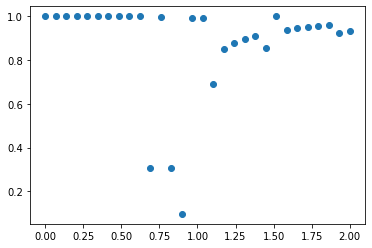

In [64]:
plt.scatter(h_arr,abs(fd_arr))

In [54]:
abs(fd_arr)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [55]:
h_arr

array([0.        , 0.02020202, 0.04040404, 0.06060606, 0.08080808,
       0.1010101 , 0.12121212, 0.14141414, 0.16161616, 0.18181818,
       0.2020202 , 0.22222222, 0.24242424, 0.26262626, 0.28282828,
       0.3030303 , 0.32323232, 0.34343434, 0.36363636, 0.38383838,
       0.4040404 , 0.42424242, 0.44444444, 0.46464646, 0.48484848,
       0.50505051, 0.52525253, 0.54545455, 0.56565657, 0.58585859,
       0.60606061, 0.62626263, 0.64646465, 0.66666667, 0.68686869,
       0.70707071, 0.72727273, 0.74747475, 0.76767677, 0.78787879,
       0.80808081, 0.82828283, 0.84848485, 0.86868687, 0.88888889,
       0.90909091, 0.92929293, 0.94949495, 0.96969697, 0.98989899,
       1.01010101, 1.03030303, 1.05050505, 1.07070707, 1.09090909,
       1.11111111, 1.13131313, 1.15151515, 1.17171717, 1.19191919,
       1.21212121, 1.23232323, 1.25252525, 1.27272727, 1.29292929,
       1.31313131, 1.33333333, 1.35353535, 1.37373737, 1.39393939,
       1.41414141, 1.43434343, 1.45454545, 1.47474747, 1.49494

In [65]:
abs(fd_arr)

array([1.        , 0.99999982, 0.99999712, 0.99998505, 1.        ,
       0.99987482, 1.        , 0.99945036, 0.99897208, 0.99999803,
       0.30662851, 0.99454738, 0.30489759, 0.09690911, 0.99366148,
       0.99192593, 0.69193901, 0.85096845, 0.87784288, 0.89684518,
       0.91098442, 0.8543413 , 0.99990718, 0.93870128, 0.94483932,
       0.95001968, 0.95452428, 0.95837912, 0.92542633, 0.93100441])

Text(0.5, 0.98, 'Infinite DMRG Phase Diagram')

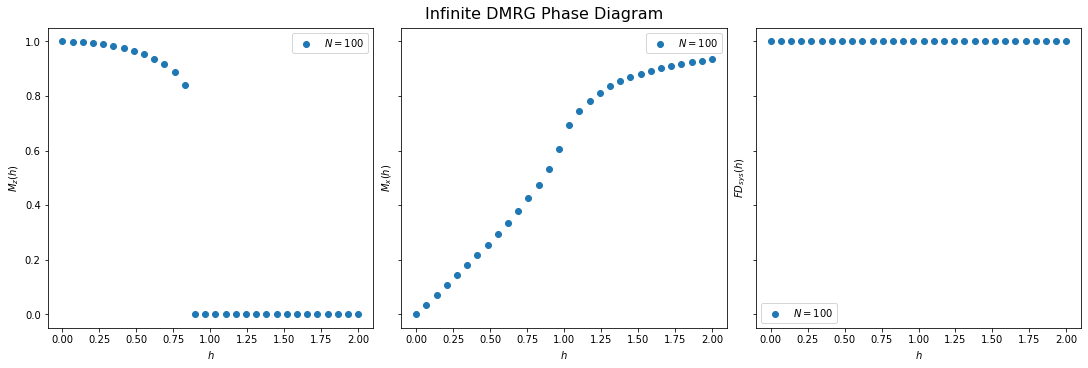

In [26]:
n = 100
fig, (fig_magz, fig_magx, fig_fd) = plt.subplots(1,3,figsize=(15, 5), constrained_layout=True, sharey=True)
fig_magz.scatter(h_arr,np.abs(magz_arr),label=r'$N= %d$'%n)
#fig_magz.set_title(r'M_(z)')
fig_magz.set_xlabel(r'$h$')
fig_magz.set_ylabel(r'$M_z(h)$')
fig_magz.legend()


fig_magx.scatter(h_arr,np.abs(magx_arr),label=r'$N= %d$'%n)
fig_magx.set_xlabel(r'$h$')
fig_magx.set_ylabel(r'$M_x(h)$')
#fig_magx.set_title('M_(x)')
fig_magx.legend()

# fig_ent_s.scatter(h_arr,np.abs(ent_s_arr),label=r'$N= %d$'%n)
# fig_ent_s.scatter(h_arr,np.log(2*np.ones(disc_point)),label=r'$ln2$')
# fig_ent_s.set_xlabel(r'$h$')
# fig_ent_s.set_ylabel(r'$S_{sys}(h)$')
# #fig_magx.set_title('M_(x)')
# fig_ent_s.legend()

fig_fd.scatter(h_arr,np.abs(fd_arr),label=r'$N= %d$'%n)
fig_fd.set_xlabel(r'$h$')
fig_fd.set_ylabel(r'$FD(h)$')
#fig_magx.set_title('M_(x)')
fig_fd.legend()

fig.suptitle('Infinite DMRG Phase Diagram', fontsize=16)
#plt.savefig('Infinite DMRG Phase Diagram N=%d.png'%n, dpi=300, bbox_inches='tight')

In [9]:
def graphic(sys_block, env_block, sys_label="l",env_label="r"):
    """Returns a graphical representation of the DMRG step we are about to
    perform, using '=' to represent the system sites, '-' to represent the
    environment sites, and '**' to represent the two intermediate sites.
    """
    assert sys_label in ("l")
    assert env_label in ("r")
    graphic = ("=" * sys_block.length) + "**" + ("-" * env_block.length)
    return graphic

In [32]:
def finite_system_algorithm(J,h,L, m_warmup, m_sweep_list):
    assert L % 2 == 0  # require that L is an even number

    # To keep things simple, this dictionary is not actually saved to disk, but
    # we use it to represent persistent storage.
    sysblock_disk = {}  # "disk" storage for Block objects
    envblock_disk = {}
    # Use the infinite system algorithm to build up to desired size.  Each time
    # we construct a block, we save it for future reference as both a left
    # ("l") and right ("r") block, as the infinite system algorithm assumes the
    # environment is a mirror image of the system.
    H1 = h*Sx1 + 1e-8*Sz1
    Magz1 = Sz1
    Magx1 = Sx1
    initial_block = SysBlock(length=1, basis_size=model_d, operator_dict={
        "H": H1,
        "Magz":Magz1,
        "Magx":Magx1,
        "conn_Sz": Sz1,
        "conn_Sx": Sx1,
        })
    sysblock = initial_block
    envblock = initial_block
    sysblock_disk["l", sysblock.length] = sysblock
    envblock_disk["r", envblock.length] = envblock
    while 2 * sysblock.length < L:
        # Perform a single DMRG step and save the new Block to "disk"
        #print(graphic(sysblock, envblock))
        sysblock, envblock, energy, expect_magz, expect_magx, psi0 = single_dmrg_step(J,h,sysblock, envblock, m=m_warmup)
        #print("E/L =", energy / (sysblock.length * 2))
        sysblock_disk["l", sysblock.length] = sysblock
        envblock_disk["r", envblock.length] = envblock

    # Now that the system is built up to its full size, we perform sweeps using
    # the finite system algorithm.  At first the left block will act as the
    # system, growing at the expense of the right block (the environment), but
    # once we come to the end of the chain these roles will be reversed.
    sys_label, env_label = "l", "r"
    sys_block = sysblock; del sysblock  # rename the sysvariable
    env_block = envblock; del envblock  # rename the envvariable
    for m in m_sweep_list:
        while True:
            # Load the appropriate environment block from "disk"
            env_block = envblock_disk[env_label, L - sys_block.length - 2]
            if env_block.length == 1:
                while True:
                # We've come to the end of the chain, so we reverse course.
#                 sys_block, env_block = env_block, sys_block
#                 sys_label, env_label = env_label, sys_label
                    sys_block = sysblock_disk[sys_label, L - env_block.length - 2]
                    env_block = envblock_disk[env_label, env_block.length]
                    #print(graphic(sys_block, env_block, sys_label),sys_block.length,env_block.length)
                    sys_block, env_block, energy, expect_magz, expect_magx, psi0 = single_dmrg_step(J,h,sys_block, env_block, m=m)
                    #print("E/L =", energy / L)
                    #print("MAGZ/L =", expect_magz[0] / L)
                    #print("MAGX/L =", expect_magx[0] / L)
                    # Save the block from this step to disk.
                    envblock_disk[env_label, env_block.length] = env_block
                    # Check whether we just completed a full sweep.
                    if env_block.length == L - 2:
                        env_block = envblock_disk[env_label, env_block.length-2]
                        break  # escape from the "while True" loop
            ## Perform a single DMRG step.
            #print(graphic(sys_block, env_block),sys_block.length,env_block.length)
            sys_block, env_block, energy, expect_magz, expect_magx, psi0 = single_dmrg_step(J,h,sys_block, env_block, m=m)
            #print("E/L =", energy / L)
            #print("MAGZ/L =", expect_magz[0] / L)
            #print("MAGX/L =", expect_magx[0] / L)
            # Save the block from this step to disk.
            sysblock_disk[sys_label, sys_block.length] = sys_block
            # Check whether we just completed a full sweep.
            if 2 * sys_block.length == L:
                break  # escape from the "while True" loop
    EXP_MAGZ = expect_magz[0] / L
    EXP_MAGX = expect_magx[0] / L
    return  energy, EXP_MAGZ,EXP_MAGX, psi0
#if __name__ == "__main__":
    #np.set_printoptions(precision=10, suppress=True, threshold=10000, linewidth=300)

    #infinite_system_algorithm(L=100, m=20)
    #finite_system_algorithm(J=-1,h=-1,L=64, m_warmup=10, m_sweep_list=[10, 20, 30, 40, 40])

In [34]:
disc_point = 30
h_arr = np.linspace(0,2,disc_point)
magz_arr = np.linspace(0,2,disc_point)
magx_arr = np.linspace(0,2,disc_point)
fd_arr = np.linspace(0,2,disc_point)
for i in range(disc_point):
    energy, EXP_MAGZ,EXP_MAGX, psi0 = finite_system_algorithm(J=-1,h=h_arr[i],L=100, m_warmup=50, m_sweep_list=[50, 50])
    energy, EXP_MAGZ,EXP_MAGX, ppsi0 = finite_system_algorithm(J=-1,h=h_arr[i]+0.001,L=100, m_warmup=50, m_sweep_list=[50, 50])
    magz_arr[i] =  EXP_MAGZ[0]
    magx_arr[i] =  EXP_MAGX[0]
    fd_arr[i] = csr_matrix.getH(psi0)@ppsi0
    print("Magz =", EXP_MAGZ[0])
    print("Magx =", EXP_MAGX[0])

Magz = -0.9999998674999244
Magx = -0.0005100000929252482
Magz = -0.9993499095101767
Magx = -0.03570471760974095
Magz = -0.9974192749652186
Magx = -0.07103043242490478
Magz = -0.9941548273499357
Magx = -0.10662117411509486
Magz = -0.9894623820197029
Magx = -0.14262123920807843
Magz = -0.9831964115276112
Magx = -0.17919178201944408
Magz = -0.9751422412847484
Magx = -0.2165196060043392
Magz = -0.9649855191733159
Magx = -0.25482976878408126
Magz = -0.9522581438818698
Magx = -0.29440492130320356
Magz = -0.9362365128355725
Magx = -0.3356171356344009
Magz = -0.9157320970546623
Magx = -0.37898474173020086
Magz = -0.8886010382316784
Magx = -0.42528506962345103
Magz = -0.8352614635595149
Magx = -0.475814207084402
Magz = -0.0017666431716563302
Magx = -0.5331549838491848
Magz = -1.4956697716161926e-06
Magx = -0.606423696530126
Magz = -1.4645259958090406e-08
Magx = -0.693080281562775
Magz = -3.5780908522187183e-09
Magx = -0.7462934130051928
Magz = -1.9034417521324178e-09
Magx = -0.7838415686906646


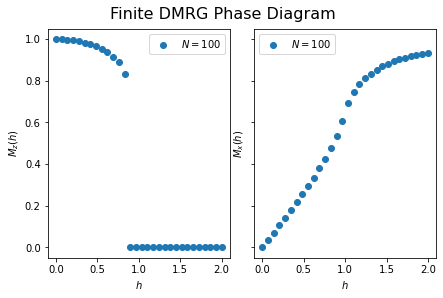

In [36]:
n = 100
fig, (fig_magz, fig_magx) = plt.subplots(1, 2, constrained_layout=True, sharey=True)
fig_magz.scatter(h_arr,np.abs(magz_arr),label=r'$N= %d$'%n)
#fig_magz.set_title(r'M_(z)')
fig_magz.set_xlabel(r'$h$')
fig_magz.set_ylabel(r'$M_z(h)$')
fig_magz.legend()


fig_magx.scatter(h_arr,np.abs(magx_arr),label=r'$N= %d$'%n)
fig_magx.set_xlabel(r'$h$')
fig_magx.set_ylabel(r'$M_x(h)$')
#fig_magx.set_title('M_(x)')
fig_magx.legend()


fig.suptitle('Finite DMRG Phase Diagram', fontsize=16)
plt.savefig('Finite DMRG Phase Diagram N=%d.png'%n, dpi=300, bbox_inches='tight')

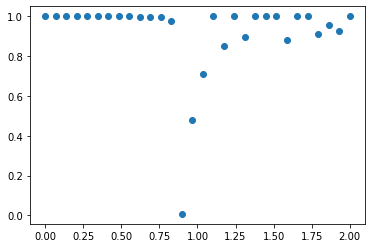

In [38]:
plt.scatter(h_arr,abs(fd_arr))